In [1]:
from collections import defaultdict
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from collections import Counter
import numpy as np

import sys
igloo_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
print(f"Adding {igloo_path} to sys.path")
sys.path.append(igloo_path)
from model.vqvae import VQVAE
from dataset import LoopSequenceDataset
from dataset import Alphabet, proteinseq_toks
from evals.metrics import eval_clusters, dihedral_distance_pairwise, eval_clusters_length_independent#

Adding /homefs/home/fanga5/cdrcluster to sys.path


In [2]:
loop_df = pd.read_parquet("/data/fanga5/preprocessed_data/sabdab_2025-05-06-paired_loops_with_sequence_id.parquet")
loop_df['loop_id'] = loop_df.apply(lambda x: f"{x['sabdab_id']}_{x['loop_type']}", axis=1)
loop_to_canonical = loop_df.set_index('loop_id')['assigned_cluster'].to_dict()
loop_to_canonical_strict = loop_df.set_index('loop_id')['assigned_cluster_D=0.1'].to_dict()
loop_to_canonical_ssc_comparison = loop_df.set_index('loop_id')['assigned_cluster_D=0.61'].to_dict()

In [3]:
model_ckpt = "../../checkpoints/igloo_weights.pt" 
model_config = "../../checkpoints/igloo_config.json"

model = VQVAE.load_from_config_and_weights(model_config, model_ckpt, strict=False)
print("Codebook size:", model.codebook_size)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
model.eval()

Codebook size: 8192
Number of parameters: 1932703


VQVAE(
  (encoder): LoopTransformer(
    (embed_tokens): Embedding(25, 128, padding_idx=3)
    (dihedral_projection): Linear(in_features=6, out_features=128, bias=True)
    (layers): ModuleList(
      (0-3): 4 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (emb_layer_norm_after): LayerNorm((128,), eps=1e-05, elementwise

In [4]:
USE_CONTEXT = False
USE_H3 = True

dataset_path_suffix = ".jsonl" if USE_H3 else "_no_H3.jsonl"
context_path = "/data/fanga5/preprocessed_data/sabdab_2025-05-06-paired_chains_lobster_24M_representations.parquet"
test_dataset = LoopSequenceDataset(f"/data/fanga5/data/test_loop_len_all_seed_42{dataset_path_suffix}", max_length=36, context_path=context_path if USE_CONTEXT else None)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)
train_dataset = LoopSequenceDataset(f"/data/fanga5/data/train_loop_len_all_seed_42{dataset_path_suffix}", max_length=36, context_path=context_path if USE_CONTEXT else None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=train_dataset.collate_fn)
val_dataset = LoopSequenceDataset(f"/data/fanga5/data/val_loop_len_all_seed_42{dataset_path_suffix}", max_length=36, context_path=context_path if USE_CONTEXT else None)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=val_dataset.collate_fn)
print(f"Dataset size: test={len(test_dataset)}, train={len(train_dataset)}, val={len(val_dataset)}")

alphabet = Alphabet(standard_toks=proteinseq_toks)

test_sequences = set([x['loop_sequence'] for x in test_dataset.data])
train_sequences = set([x['loop_sequence'] for x in train_dataset.data])
val_sequences = set([x['loop_sequence'] for x in val_dataset.data])
print(f"Number of unique sequences: test={len(test_sequences)}, train={len(train_sequences)}, val={len(val_sequences)}")
print(f"Test, val overlap: {len(test_sequences.intersection(val_sequences))} sequences")
print(f"Test, train overlap: {len(test_sequences.intersection(train_sequences))} sequences")
print(f"Train, val overlap: {len(train_sequences.intersection(val_sequences))} sequences")

Dataset size: test=7442, train=108167, val=7090
Number of unique sequences: test=2041, train=17820, val=1899
Test, val overlap: 0 sequences
Test, train overlap: 0 sequences
Train, val overlap: 0 sequences


In [5]:
dataset = test_dataset
dataloader = test_dataloader
dataset.inference = True

loss_fn = torch.nn.MSELoss()
all_quantized_indices = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                if key == 'id':
                    continue
                batch[key] = batch[key].to(device)
        output = model(batch, val=True)
        all_quantized_indices.append(output.quantized_indices.detach().cpu())
all_quantized_indices = torch.cat(all_quantized_indices, dim=0)

100%|██████████| 233/233 [00:17<00:00, 13.38it/s]


  2%|▏         | 4/233 [00:00<00:29,  7.87it/s]

100%|██████████| 233/233 [00:21<00:00, 10.96it/s]


Masked AA Recovery: 0.5307
Masked AA Recovery for loop type L1: 0.6749
Masked AA Recovery for loop type L2: 0.5632
Masked AA Recovery for loop type L3: 0.4989
Masked AA Recovery for loop type L4: 0.6187
Masked AA Recovery for loop type H1: 0.6249
Masked AA Recovery for loop type H2: 0.5025
Masked AA Recovery for loop type H3: 0.4059
Masked AA Recovery for loop type H4: 0.5176


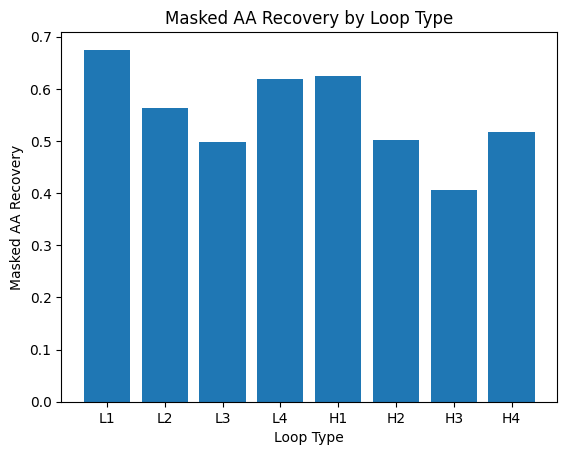

100%|██████████| 233/233 [00:21<00:00, 10.92it/s]


In [6]:
# separate by loop type
# also becareful about masked aas, they need to be discarded 
model.to('cpu')

# repeat but with no sequence information
loss_fn = torch.nn.MSELoss()
gt_aa_loop_types = defaultdict(list)
pred_aa_loop_types = defaultdict(list)
gt_aa_list = []
pred_aa_list = []
all_quantized_indices_dihedral_only = []
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        # mask out sequence information
        batch_mask = torch.zeros_like(batch['sequence'], dtype=torch.bool)
        for tok in dataset.alphabet.standard_toks:
            tok_idx = dataset.alphabet.get_idx(tok)
            batch_mask |= (batch['sequence'] == tok_idx)
        batch['sequence'][batch_mask] = dataset.alphabet.mask_idx
        output = model(batch, val=True)

        # get masked aa recovery by loop type
        curr_idx = 0
        for i in range(batch_mask.shape[0]):
            loop_type = batch['id'][i].split('_')[1]
            num_masked = batch_mask[i].sum().item()
            gt_aa_loop_types[loop_type].append(output.true_aa[curr_idx:curr_idx + num_masked].numpy())
            pred_aa_loop_types[loop_type].append(output.pred_aa[curr_idx:curr_idx + num_masked].argmax(dim=-1).numpy())
            curr_idx += num_masked

        gt_aa_list.append(output.true_aa)
        pred_aa = output.pred_aa.argmax(dim=-1).numpy()
        pred_aa_list.append(pred_aa)
        all_quantized_indices_dihedral_only.append(output.quantized_indices)
all_quantized_indices_dihedral_only = torch.cat(all_quantized_indices_dihedral_only, dim=0)

masked_aa_recovery = np.mean(np.concatenate(pred_aa_list) == np.concatenate(gt_aa_list))
print(f"Masked AA Recovery: {masked_aa_recovery:.4g}")

x = ['L1', 'L2', 'L3', 'L4', 'H1', 'H2', 'H3', 'H4']
y = []
for loop_type in x:
    if loop_type not in gt_aa_loop_types:
        y.append(0.0)
        print(f"Loop type {loop_type} not found in dataset, skipping.")
        continue
    gt_aa_loop_types[loop_type] = np.concatenate(gt_aa_loop_types[loop_type])
    pred_aa_loop_types[loop_type] = np.concatenate(pred_aa_loop_types[loop_type])
    masked_aa_recovery = np.mean(pred_aa_loop_types[loop_type] == gt_aa_loop_types[loop_type])
    y.append(masked_aa_recovery)
    print(f"Masked AA Recovery for loop type {loop_type}: {masked_aa_recovery:.4g}")

plt.bar(x, y)
plt.xlabel("Loop Type")
plt.ylabel("Masked AA Recovery")
plt.title("Masked AA Recovery by Loop Type")
plt.show()

# repeat but with no dihedral information
loss_fn = torch.nn.MSELoss()
all_quantized_indices_sequence_only = []
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        # mask out dihedral information
        batch_mask = torch.zeros_like(batch['sequence'], dtype=torch.bool)
        for tok in dataset.alphabet.standard_toks:
            tok_idx = dataset.alphabet.get_idx(tok)
            batch_mask |= (batch['sequence'] == tok_idx)
        batch['angles_mask'] = batch_mask # True = masked out
        output = model(batch, val=True)
        all_quantized_indices_sequence_only.append(output.quantized_indices)
all_quantized_indices_sequence_only = torch.cat(all_quantized_indices_sequence_only, dim=0)

In [7]:
unique, counts = np.unique(all_quantized_indices.numpy(), return_counts=True)
print("Codebook size:", model.codebook_size, "num used:", len(unique))

Codebook size: 8192 num used: 790


In [8]:
ground_truth = [loop_to_canonical[x['loop_id']] for x in dataset.data]
ground_truth_strict = [loop_to_canonical_strict[x['loop_id']] for x in dataset.data]
ground_truth_ssc_comparison = [loop_to_canonical_ssc_comparison[x['loop_id']] for x in dataset.data]
clusters_to_indices = {}
for i, cluster in enumerate(set(ground_truth)):
    clusters_to_indices[cluster] = i

results_df = pd.DataFrame({
    'loop_id': [x['loop_id'] for x in dataset.data],
    'loop_type': [x['loop_id'].split('_')[1] for x in dataset.data],
    'loop_length': [len(x['loop_sequence']) for x in dataset.data],
    'canonical_cluster': ground_truth,
    'canonical_cluster_strict': ground_truth_strict,
    'canonical_cluster_ssc_comparison': ground_truth_ssc_comparison,
    'quantized_index': all_quantized_indices.tolist(),
    'quantized_index_dihedral_only': all_quantized_indices_dihedral_only.tolist(),
    'quantized_index_sequence_only': all_quantized_indices_sequence_only.tolist(),
})

print("Number of canonical clusters:", len(set(ground_truth)))
print("Number of VQVAE clusters:", len(set(all_quantized_indices.numpy())))

Number of canonical clusters: 134
Number of VQVAE clusters: 790


In [11]:
lengths_per_cluster = results_df.groupby('quantized_index').agg(cluster_size=('loop_length', 'count'), loop_type=('loop_type', Counter), loop_length=('loop_length', Counter), num_loop_lengths=('loop_length', 'nunique')).reset_index().sort_values('num_loop_lengths', ascending=False)
lengths_per_cluster['has_H3'] = lengths_per_cluster['loop_type'].apply(lambda x: 'H3' in x)

lengths_per_cluster['loop_type_purity'] = lengths_per_cluster['loop_type'].apply(lambda x: max(x.values()) / sum(x.values()))
loop_type_purity = (lengths_per_cluster['loop_type_purity'] * lengths_per_cluster['cluster_size']).sum() / lengths_per_cluster['cluster_size'].sum()
print(f"Weighted loop type purity: {loop_type_purity:.4g}")

lengths_per_cluster['loop_length_purity'] = lengths_per_cluster['loop_length'].apply(lambda x: max(x.values()) / sum(x.values()))
loop_length_purity = (lengths_per_cluster['loop_length_purity'] * lengths_per_cluster['cluster_size']).sum() / lengths_per_cluster['cluster_size'].sum()
print(f"Weighted loop length purity: {loop_length_purity:.4g}")
print("Number of clusters with multiple loop lengths:", len(lengths_per_cluster[lengths_per_cluster['num_loop_lengths'] > 1]), "out of", len(lengths_per_cluster))

clusters_of_diff_length_with_H3 = len(lengths_per_cluster[(lengths_per_cluster['num_loop_lengths'] > 1) & (lengths_per_cluster['has_H3'])])
print(f"Clusters with multiple loop lengths that have H3: {clusters_of_diff_length_with_H3} out of {len(lengths_per_cluster[lengths_per_cluster['has_H3']])}")

lengths_per_cluster.head(20)

Weighted loop type purity: 0.9807
Weighted loop length purity: 0.9604
Number of clusters with multiple loop lengths: 128 out of 790
Clusters with multiple loop lengths that have H3: 101 out of 346


,quantized_index,cluster_size,loop_type,loop_length,num_loop_lengths,has_H3,loop_type_purity,loop_length_purity
198,2044,26,{'H3': 26},"{16: 8, 19: 1, 14: 9, 20: 1, 12: 2, 10: 2, 9: 3}",7,True,1.000000,0.346154
522,5363,8,"{'H3': 4, 'H2': 3, 'L3': 1}","{13: 3, 10: 2, 16: 1, 14: 1, 9: 1}",5,True,0.500000,0.375000
755,7809,11,"{'L3': 1, 'H3': 10}","{11: 1, 16: 8, 12: 1, 19: 1}",4,True,0.909091,0.727273
102,1031,36,{'H3': 36},"{20: 1, 14: 8, 15: 25, 16: 2}",4,True,1.000000,0.694444
521,5351,8,{'L1': 8},"{12: 2, 13: 1, 15: 3, 11: 2}",4,False,1.000000,0.375000
259,2687,5,{'H3': 5},"{14: 1, 11: 2, 15: 1, 12: 1}",4,True,1.000000,0.400000
166,1719,7,"{'L1': 1, 'H3': 4, 'L3': 2}","{14: 3, 10: 1, 13: 2, 11: 1}",4,True,0.571429,0.428571
620,6260,4,"{'H3': 3, 'L3': 1}","{19: 1, 12: 1, 18: 1, 11: 1}",4,True,0.750000,0.250000
38,364,4,"{'L1': 2, 'L3': 2}","{13: 1, 10: 1, 14: 1, 12: 1}",4,False,0.500000,0.250000
271,2824,13,{'H3': 13},"{19: 1, 13: 2, 15: 8, 16: 2}",4,True,1.000000,0.615385


In [ ]:
# ground_truth_indices = []
# test_indicies = []
# dataset_indices = []
# for i, (gt, test) in enumerate(zip(ground_truth, all_quantized_indices)):
#     if gt.endswith("-*"):
#         continue
#     ground_truth_indices.append(clusters_to_indices[gt])
#     test_indicies.append(test.item())
#     dataset_indices.append(i)

# nmi = normalized_mutual_info_score(ground_truth_indices, test_indicies)
# print(f"NMI: {nmi:.3f}")
# ari = adjusted_rand_score(ground_truth_indices, test_indicies)
# print(f"ARI: {ari:.3f}")

# all_angles = np.array([dataset[i]['angles'] for i in range(len(dataset))])
# all_tokens = np.array([dataset[i]['sequence'] for i in range(len(dataset))])
# all_loop_coords = np.array([dataset[i]['loop_c_alpha_coords'] for i in range(len(dataset))])
# all_stem_coords = np.array([dataset[i]['stem_c_alpha_coords'] for i in range(len(dataset))])

# special_tokens_mask = (
#     (all_tokens == alphabet.cls_idx) | (all_tokens == alphabet.eos_idx) | (all_tokens == alphabet.padding_idx)
# )

# all_angles_with_canonical = all_angles[dataset_indices]

# print("\nFor Kelow Clusters")
# correct, angle1, angle2, angle3 = eval_clusters_length_independent(
#     all_angles[dataset_indices], all_loop_coords[dataset_indices], all_stem_coords[dataset_indices],
#     np.array(ground_truth_indices), ~special_tokens_mask[dataset_indices])
# print(f"Proportion of pairs in a cluster that are within 0.47 radians of each other: {correct:4f}")
# print(f"Angle variance of the clusters: {angle1:4f}, {angle2:4f}, {angle3:4f}")

# print("\nFor VQVAE Clusters")
# correct, angle1, angle2, angle3 = eval_clusters_length_independent(
#     all_angles[dataset_indices], all_loop_coords[dataset_indices], all_stem_coords[dataset_indices],
#     np.array(test_indicies), ~special_tokens_mask[dataset_indices])
# print(f"Proportion of pairs in a cluster that are within 0.47 radians of each other: {correct:4f}")
# print(f"Angle variance of the clusters: {angle1:4f}, {angle2:4f}, {angle3:4f}")

# print("\nFor VQVAE Clusters (including noise)")
# correct, angle1, angle2, angle3 = eval_clusters_length_independent(
#     all_angles, all_loop_coords, all_stem_coords,
#     all_quantized_indices.numpy(), ~special_tokens_mask)
# print(f"Proportion of pairs in a cluster that are within 0.47 radians of each other: {correct:4f}")
# print(f"Angle variance of the clusters: {angle1:4f}, {angle2:4f}, {angle3:4f}")

In [ ]:
# this is quite intensive to run, can crash kernel
# dataset_dihedral_distance = dihedral_distance_pairwise(all_angles, mask=~special_tokens_mask)
# sil_score = silhouette_score(dataset_dihedral_distance, all_quantized_indices, metric='precomputed')
# print(f"Silhouette Score: {sil_score:.3f}")

In [ ]:
# proportion_within_threshold_kelow, circular_variance_kelow = eval_clusters(np.array([dataset[i]['angles'] for i in dataset_indices]), np.array(ground_truth_indices), return_mean=False)
# proportion_within_threshold, circular_variance = eval_clusters(np.array([dataset[i]['angles'] for i in range(len(dataset))]), all_quantized_indices.numpy(), return_mean=False)
# clusters, counts = np.unique(all_quantized_indices.numpy(), return_counts=True)
# clusters_var_df = pd.DataFrame({
#     'cluster': clusters,
#     'cluster_size': counts,
#     'proportion_within_threshold': proportion_within_threshold,
#     'phi': circular_variance[:, 0],
#     'psi': circular_variance[:, 1],
#     'omega': circular_variance[:, 2],
# })
# clusters_var_df.sort_values(by='proportion_within_threshold', ascending=True)

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4))
# bins = np.linspace(0, 1, 50)
# axes[0].hist(proportion_within_threshold_kelow, bins=bins, alpha=0.5, label='Kelow Clusters', density=True)
# axes[0].hist(proportion_within_threshold, bins=bins, alpha=0.5, label='VQVAE Clusters', density=True)
# axes[0].set_xlabel('Proportion of pairs within threshold')
# axes[0].set_ylabel('Frequency')
# axes[0].set_title('Distribution of Proportion of Pairs \n Within Threshold across Clusters')
# axes[0].legend()

# angle_bins = np.linspace(0, 0.5, 50)
# axes[1].hist(circular_variance_kelow[:, 0], bins=angle_bins, alpha=0.5, label='Kelow Clusters', density=True)
# axes[1].hist(circular_variance[:, 0], bins=angle_bins, alpha=0.5, label='VQVAE Clusters', density=True)
# axes[1].set_xlabel('Circular Variance (radians)')
# axes[1].set_ylabel('Frequency')
# axes[1].set_title('Distribution of Circular Variance \n (phi) across Clusters')
# axes[2].hist(circular_variance_kelow[:, 1], bins=angle_bins, alpha=0.5, label='Kelow Clusters', density=True)
# axes[2].hist(circular_variance[:, 1], bins=angle_bins, alpha=0.5, label='VQVAE Clusters', density=True)
# axes[2].set_xlabel('Circular Variance (radians)')
# axes[2].set_ylabel('Frequency')
# axes[2].set_title('Distribution of Circular Variance \n (psi) across Clusters')
# axes[3].hist(circular_variance_kelow[:, 2], bins=angle_bins, alpha=0.5, label='Kelow Clusters', density=True)
# axes[3].hist(circular_variance[:, 2], bins=angle_bins, alpha=0.5, label='VQVAE Clusters', density=True)
# axes[3].set_xlabel('Circular Variance (radians)')
# axes[3].set_ylabel('Frequency')
# axes[3].set_title('Distribution of Circular Variance \n (omega) across Clusters')


# _, cluster_counts = np.unique(np.array(ground_truth_indices, dtype=np.int64, copy=True), return_counts=True)
# _, vqvae_counts = np.unique(np.array(all_quantized_indices, dtype=np.int64, copy=True), return_counts=True)
# count_bins = np.linspace(0, max(max(cluster_counts), max(vqvae_counts)), 50)
# axes[4].hist(cluster_counts, bins=count_bins, alpha=0.5, label='Kelow Clusters', density=True)
# axes[4].hist(vqvae_counts, bins=count_bins, alpha=0.5, label='VQVAE Clusters', density=True)
# axes[4].set_xlabel('Cluster Size')
# axes[4].set_ylabel('Frequency')
# axes[4].set_title('Distribution of Cluster Sizes')
# axes[4].legend()

# plt.tight_layout()


## How pure are the VQVAE clusters compared to canonical clusters

In [12]:
print("Numuber of unique canonical clusters:", results_df['canonical_cluster'].nunique())
print("Num noise clusters:", len(results_df[results_df['canonical_cluster'].str.endswith("-*")]['canonical_cluster'].unique()))

Numuber of unique canonical clusters: 134
Num noise clusters: 64


In [13]:
agg_results = None
for dihedral_cutoff, canonical_cluster_key in [(0.61, 'canonical_cluster_ssc_comparison'), (0.47, 'canonical_cluster'), (0.1, 'canonical_cluster_strict')]:
    vqvae_to_canonical = (
    results_df
        .groupby('quantized_index')
        .agg(
            cluster_size = ('quantized_index', 'size'),
            canonical_cluster_nunique = (canonical_cluster_key, 'nunique'),
            canonical_cluster_set = (canonical_cluster_key, Counter),
        ).reset_index().sort_values('canonical_cluster_nunique', ascending=False)
    )
    vqvae_to_canonical['most_common_canonical_cluster'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: x.most_common(1)[0][0] if x else None)
    vqvae_to_canonical['canonical_cluster_set'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: sorted(x.items(), key=lambda y: y[1], reverse=True))
    vqvae_to_canonical_map = vqvae_to_canonical.set_index('quantized_index')['most_common_canonical_cluster'].to_dict()
    
    results_df[f'{canonical_cluster_key}_vqvae'] = results_df['quantized_index'].map(vqvae_to_canonical_map)
    mask = ~results_df[canonical_cluster_key].str.endswith("-*")
    purity = (results_df[canonical_cluster_key][mask] == results_df[f'{canonical_cluster_key}_vqvae'][mask]).sum() / len(results_df[mask])
    print(f"Purity of VQVAE clusters wrt canonical clusters (D={dihedral_cutoff}): {purity:.3f}")

    results_df['correct_assignment'] = results_df[canonical_cluster_key] == results_df[f'{canonical_cluster_key}_vqvae']
    agg_results_ = results_df[~results_df[canonical_cluster_key].str.endswith("-*")].groupby(['loop_type']).agg(prop_correct=('correct_assignment', 'mean')).reset_index()
    agg_results_.rename(columns={'prop_correct': f'prop_correct (D={dihedral_cutoff})'}, inplace=True)
    if agg_results is None:
        agg_results = agg_results_
    else:
        agg_results = agg_results.merge(agg_results_, on='loop_type')
agg_results

Purity of VQVAE clusters wrt canonical clusters (D=0.61): 0.869
Purity of VQVAE clusters wrt canonical clusters (D=0.47): 0.873
Purity of VQVAE clusters wrt canonical clusters (D=0.1): 0.888


,loop_type,prop_correct (D=0.61),prop_correct (D=0.47),prop_correct (D=0.1)
0,H1,0.837381,0.855670,0.930470
1,H2,0.912534,0.912844,0.906780
2,H3,0.748031,0.705882,0.586207
3,H4,0.991254,0.997006,0.996575
4,L1,0.883316,0.883495,0.879643
5,L2,0.996933,0.972222,0.750000
6,L3,0.790373,0.796249,0.835928
7,L4,0.892857,0.892157,0.895833


### How pure are the clusters if we use dihedral only

In [14]:
agg_results = None
for dihedral_cutoff, canonical_cluster_key in [(0.61, 'canonical_cluster_ssc_comparison'), (0.47, 'canonical_cluster'), (0.1, 'canonical_cluster_strict')]:
    vqvae_to_canonical = (
    results_df
        .groupby('quantized_index_dihedral_only')
        .agg(
            cluster_size = ('quantized_index_dihedral_only', 'size'),
            canonical_cluster_nunique = (canonical_cluster_key, 'nunique'),
            canonical_cluster_set = (canonical_cluster_key, Counter),
        ).reset_index().sort_values('canonical_cluster_nunique', ascending=False)
    )
    vqvae_to_canonical['most_common_canonical_cluster'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: x.most_common(1)[0][0] if x else None)
    vqvae_to_canonical['canonical_cluster_set'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: sorted(x.items(), key=lambda y: y[1], reverse=True))
    vqvae_to_canonical_map = vqvae_to_canonical.set_index('quantized_index_dihedral_only')['most_common_canonical_cluster'].to_dict()
    
    results_df[f'{canonical_cluster_key}_vqvae'] = results_df['quantized_index_dihedral_only'].map(vqvae_to_canonical_map)
    mask = ~results_df[canonical_cluster_key].str.endswith("-*")
    purity = (results_df[canonical_cluster_key][mask] == results_df[f'{canonical_cluster_key}_vqvae'][mask]).sum() / len(results_df[mask])
    print(f"Purity of VQVAE clusters wrt canonical clusters (D={dihedral_cutoff}): {purity:.3f}")

    results_df['correct_assignment'] = results_df[canonical_cluster_key] == results_df[f'{canonical_cluster_key}_vqvae']
    agg_results_ = results_df[~results_df[canonical_cluster_key].str.endswith("-*")].groupby(['loop_type']).agg(prop_correct=('correct_assignment', 'mean')).reset_index()
    agg_results_.rename(columns={'prop_correct': f'prop_correct (D={dihedral_cutoff})'}, inplace=True)
    if agg_results is None:
        agg_results = agg_results_
    else:
        agg_results = agg_results.merge(agg_results_, on='loop_type')
agg_results

Purity of VQVAE clusters wrt canonical clusters (D=0.61): 0.858
Purity of VQVAE clusters wrt canonical clusters (D=0.47): 0.859
Purity of VQVAE clusters wrt canonical clusters (D=0.1): 0.874


,loop_type,prop_correct (D=0.61),prop_correct (D=0.47),prop_correct (D=0.1)
0,H1,0.845829,0.847652,0.934560
1,H2,0.905320,0.909174,0.920097
2,H3,0.730315,0.712418,0.724138
3,H4,0.962099,0.946108,0.982877
4,L1,0.871034,0.851133,0.857355
5,L2,0.992331,0.994792,0.750000
6,L3,0.771739,0.773231,0.780838
7,L4,0.875000,0.872549,0.864583


### How pure are the clusters if we use sequence only

In [15]:
agg_results = None
for dihedral_cutoff, canonical_cluster_key in [(0.61, 'canonical_cluster_ssc_comparison'), (0.47, 'canonical_cluster'), (0.1, 'canonical_cluster_strict')]:
    vqvae_to_canonical = (
    results_df
        .groupby('quantized_index_sequence_only')
        .agg(
            cluster_size = ('quantized_index_sequence_only', 'size'),
            canonical_cluster_nunique = (canonical_cluster_key, 'nunique'),
            canonical_cluster_set = (canonical_cluster_key, Counter),
        ).reset_index().sort_values('canonical_cluster_nunique', ascending=False)
    )
    vqvae_to_canonical['most_common_canonical_cluster'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: x.most_common(1)[0][0] if x else None)
    vqvae_to_canonical['canonical_cluster_set'] = vqvae_to_canonical['canonical_cluster_set'].apply(lambda x: sorted(x.items(), key=lambda y: y[1], reverse=True))
    vqvae_to_canonical_map = vqvae_to_canonical.set_index('quantized_index_sequence_only')['most_common_canonical_cluster'].to_dict()
    
    results_df[f'{canonical_cluster_key}_vqvae'] = results_df['quantized_index_sequence_only'].map(vqvae_to_canonical_map)
    mask = ~results_df[canonical_cluster_key].str.endswith("-*")
    purity = (results_df[canonical_cluster_key][mask] == results_df[f'{canonical_cluster_key}_vqvae'][mask]).sum() / len(results_df[mask])
    print(f"Purity of VQVAE clusters wrt canonical clusters (D={dihedral_cutoff}): {purity:.3f}")

    results_df['correct_assignment'] = results_df[canonical_cluster_key] == results_df[f'{canonical_cluster_key}_vqvae']
    agg_results_ = results_df[~results_df[canonical_cluster_key].str.endswith("-*")].groupby(['loop_type']).agg(prop_correct=('correct_assignment', 'mean')).reset_index()
    agg_results_.rename(columns={'prop_correct': f'prop_correct (D={dihedral_cutoff})'}, inplace=True)
    if agg_results is None:
        agg_results = agg_results_
    else:
        agg_results = agg_results.merge(agg_results_, on='loop_type')
agg_results

Purity of VQVAE clusters wrt canonical clusters (D=0.61): 0.855
Purity of VQVAE clusters wrt canonical clusters (D=0.47): 0.865
Purity of VQVAE clusters wrt canonical clusters (D=0.1): 0.862


,loop_type,prop_correct (D=0.61),prop_correct (D=0.47),prop_correct (D=0.1)
0,H1,0.819430,0.838488,0.856851
1,H2,0.902615,0.908257,0.898305
2,H3,0.596457,0.552288,0.224138
3,H4,0.997085,1.000000,0.996575
4,L1,0.889458,0.889968,0.875186
5,L2,0.995399,0.994792,0.125000
6,L3,0.807453,0.804774,0.827545
7,L4,0.875000,0.872549,0.875000
